In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
from dataclasses import dataclass
import math
import time
import inspect
from pathlib import Path
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
from torch.nn import functional as F

# distributed training
from torch.distributed import init_process_group, destroy_process_group
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist


In [3]:
!nvidia-smi

Tue Aug  5 20:52:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GH200 480GB             On  |   00000000:DD:00.0 Off |                    0 |
| N/A   52C    P0             73W /  700W |       9MiB /  97871MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
torch.manual_seed(1337)
random.seed(1337)
data_path = Path('/home/ubuntu/data')
log_path = Path('/home/ubuntu/log')
model_path = Path('/home/ubuntu/model')


def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

device = get_device()

using cuda


## Model

In [5]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        # ensures that you can split embeddings across the heads
        assert config.n_embd % config.n_head == 0
        # key, query, value projection for all heads in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, n_embd embedding dimensionality 
        # calculate query, key, value for all heads in batch, then move head forward
        # nh - num heads, hs - head size, C  nh*hs aka channels
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        # y = att @ v # (B, nh, T, T) X (B, nh, T, hs) - > (B, nh, T, hs)
        # replace attention with flash attention 
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        # allows for pathway to pass through gradients instead of going through each "box"
        # this is a feed forward network
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length/context
    vocab_size: int = 100276 # switched to GP4 tokenizer 
    n_layer: int = 12 
    n_head: int = 12
    n_embd: int = 768

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd), # weight tokenizer element
            wpe = nn.Embedding(config.block_size, config.n_embd), # weight position element
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # hidden layers aka Transformers
            ln_f = nn.LayerNorm(config.n_embd), #log normalization 
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # language model head going from embeddings to vocab

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        mean = 0.0
        if isinstance(module, nn.Linear):
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=mean, std=std)

    def forward(self, idx, targets=None):
        # idx is shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f'Cannot forward sequence, out of context'
        # forward the token and positions
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # (T, n_embd)
        tok_emb = self.transformer.wte(idx) # (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the block
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and head
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        if master_process:
            print(f'num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters')
            print(f'num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters')
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        if master_process:
            print(f'using fused AdamW: {use_fused}')
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer

In [6]:
def load_tokens(filename):
    print(f'loading {filename}')
    npt = np.load(filename)
    npt = npt.astype(np.int32)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

class DataLoaderLite:
    def __init__(self, B, T, process_rank, num_processes, split):
        self.B = B
        self.T = T
        self.process_rank = process_rank
        self.num_processes = num_processes
        assert split in {'train','test','val'}

        # get the shard filenames
        data_root = data_path / f'{split}'
        shards = list(data_root.iterdir())
        self.shards = sorted(shards)
        assert len(shards) > 0, f'no shards found for split {split}'
        if master_process:
            print(f'found {len(shards)} shards for split {split}')
        self.reset()

    def reset(self):
        # state, init at shard zero
        self.remaining_shards = self.shards
        random.shuffle(self.remaining_shards)
        self.current_shard = 0
        self.tokens = load_tokens(self.remaining_shards[self.current_shard])
        self.current_position = self.B * self.T * self.process_rank

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        if len(buf) < B * T + 1:
            self.current_shard += 1
            if self.current_shard >= len(self.remaining_shards):
                self.reset()
            self.tokens = load_tokens(self.remaining_shards[self.current_shard])
            self.current_position = B * T * self.process_rank
            return self.next_batch()
        x = (buf[:-1]).view(B, T)
        y = (buf[1:]).view(B, T)
        self.current_position += B * T * self.num_processes
        return x, y

## Setup distributed run

In [7]:
# set up DDP (distributed data parallel).
# torchrun command sets the env variables RANK, LOCAL_RANK, and WORLD_SIZE
device_type = device # override device if using ddp do device_type acts as backup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    # use of DDP atm demands CUDA, we set the device appropriately according to rank
    assert torch.cuda.is_available(), 'for now i think we need CUDA for DDP'
    init_process_group(backend='nccl')
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
else:
    # vanilla, non-DDP run
    ddp_rank = 0
    ddp_local_rank = 0
    ddp_world_size = 1
    master_process = True
    print(f'not using ddp, using device: {device}')

not using ddp, using device: cuda


In [8]:
total_batch_size = 589824 #524288 # 2**19, ~0.5M, in number of tokens, made smaller for testing 
B = 96 # micro batch size
T = 1024 # sequence length
assert total_batch_size % (B * T * ddp_world_size) == 0, 'make sure total_batch_size is divisible by B * T * ddp_world_size'
grad_accum_steps = total_batch_size // (B * T * ddp_world_size)
if master_process:
    print(f'total desired batch size: {total_batch_size}')
    print(f'=> calculated gradient accumulation steps: {grad_accum_steps}')

train_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split='train')
test_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split='test')

torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig(vocab_size=100608)) # make divisible by power of 2 was 50304
model.to(device)
model = torch.compile(model)
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])
    
raw_model = model.module if ddp else model # always contains the "raw" unwrapped model
lossi = []

total desired batch size: 589824
=> calculated gradient accumulation steps: 6
found 153 shards for split train
loading /home/ubuntu/data/train/train_fineweb_edu_000015.npy
found 1 shards for split test
loading /home/ubuntu/data/test/test_fineweb_edu_000000.npy


In [24]:
max_lr = 8e-5 # match what LR was at 10k
min_lr = max_lr * 0.01
max_steps = 10000 
warmup_steps = 0.001 * max_steps # 5% warmup
weight_decay = 0.1
def get_lr(it):
    # 1/ linear warmup 
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2/ if iterations > lr_decay_iters, return min learning rate
    if it > max_steps: 
        return min_lr

    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

In [25]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.95), eps=1e-8)
optimizer = raw_model.configure_optimizers(weight_decay=0.1, learning_rate=max_lr, device_type=device_type)
enc = tiktoken.get_encoding('cl100k_base')

num decayed parameter tensors: 50, with 162,988,032 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True


In [26]:
log_file = log_path / 'log_restart2.txt'
with open(log_file, 'w') as f: # open for writing to clear the file
    pass

In [27]:
for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps - 1)
    
    # once in a while evaluate our test loss
    if step % 500 == 0 or last_step:
        model.eval()
        test_loader.reset()
        with torch.no_grad():
            test_loss_accum = 0.0
            test_loss_steps = 20
            for _ in range(test_loss_steps):
                x, y = test_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(x, y)
                loss = loss / test_loss_steps
                test_loss_accum += loss.detach()
        if ddp:
            dist.all_reduce(test_loss_accum, op=dist.ReduceOp.AVG)
        if master_process:
            print(f'test loss: {test_loss_accum.item():.4f}')
            with open(log_file, "a") as f:
                f.write(f'{step} test {test_loss_accum.item():.4f}\n')
            if step > 0 and (step % 1000 == 0 or last_step):
                # optionally write model checkpoints
                checkpoint_path = model_path / f'model_{step:05d}.pt'
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'config': raw_model.config,
                    'step': step,
                    'test_loss': test_loss_accum.item()
                }
                # you might also want to add optimizer.state_dict() and
                # rng seeds etc., if you wanted to more exactly resume training
                torch.save(checkpoint, checkpoint_path)

    # once in a while generate from the model (except step 0, which is noise)
    if ((step > 0 and step % 500 == 0) or last_step):
        model.eval()
        num_return_sequences = 2
        max_length = 32
        tokens = enc.encode('Hello, I\'m a language model,')
        tokens = torch.tensor(tokens, dtype=torch.long)
        tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
        xgen = tokens.to(device)
        sample_rng = torch.Generator(device=device)
        sample_rng.manual_seed(42 + ddp_rank)
        while xgen.size(1) < max_length:
            # forward the model to get the logits
            with torch.no_grad():
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(xgen) # (B, T, vocab_size)
                # take the logits at the last position
                logits = logits[:, -1, :] # (B, vocab_size)
                # get the probabilities
                probs = F.softmax(logits, dim=-1)
                # do top-k sampling of 50 (huggingface pipeline default)
                # topk_probs here becomes (5, 50), topk_indices is (5, 50)
                topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
                # select a token from the top-k probabilities
                # note: multinomial does not demand the input to sum to 1
                ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
                # gather the corresponding indices
                xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
                # append to the sequence
                xgen = torch.cat((xgen, xcol), dim=1)
        # print the generated text
        for i in range(num_return_sequences):
            tokens = xgen[i, :max_length].tolist()
            decoded = enc.decode(tokens)
            print(f'rank {ddp_rank} sample {i}: {decoded}')

    # do one step of the optimization
    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        # added after video, this field is also used by the forward pass.
        if ddp:
            model.require_backward_grad_sync = (micro_step == grad_accum_steps - 1)
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    if ddp:
        dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)
    # determine and set the learning rate for this iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    if device_type == 'cuda':
        torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = t1 - t0 # time difference in seconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps * ddp_world_size
    tokens_per_sec = tokens_processed / dt
    if master_process:
        lossi.append(loss_accum.item())
        print(f'step {step:5d} | loss: {loss_accum.item():.6f} | lr {lr:.4e}| dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}')
        with open(log_file, 'a') as f:
            f.write(f'{step} train {loss_accum.item():.6f}\n')

loading /home/ubuntu/data/test/test_fineweb_edu_000000.npy
test loss: 3.1051
step     0 | loss: 3.221662 | lr 8.0000e-06| dt: 3224.47ms | tok/sec: 182921.42
step     1 | loss: 3.294290 | lr 1.6000e-05| dt: 1534.80ms | tok/sec: 384299.09
step     2 | loss: 3.358116 | lr 2.4000e-05| dt: 1532.99ms | tok/sec: 384753.26
step     3 | loss: 3.094645 | lr 3.2000e-05| dt: 1518.23ms | tok/sec: 388494.20
step     4 | loss: 2.887194 | lr 4.0000e-05| dt: 1535.62ms | tok/sec: 384093.84
step     5 | loss: 3.120780 | lr 4.8000e-05| dt: 1537.38ms | tok/sec: 383654.48
step     6 | loss: 3.370338 | lr 5.6000e-05| dt: 1541.17ms | tok/sec: 382712.87
step     7 | loss: 3.096313 | lr 6.4000e-05| dt: 1540.79ms | tok/sec: 382806.08
step     8 | loss: 3.342914 | lr 7.2000e-05| dt: 1542.01ms | tok/sec: 382504.46
step     9 | loss: 3.198452 | lr 8.0000e-05| dt: 1537.10ms | tok/sec: 383726.13
step    10 | loss: 3.297235 | lr 8.0000e-05| dt: 1538.81ms | tok/sec: 383299.43
step    11 | loss: 3.216801 | lr 8.0000e-05

In [28]:
if ddp:
    destroy_process_group()

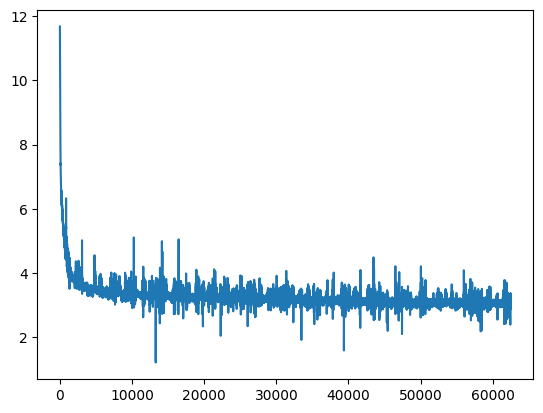

In [29]:
plt.plot(lossi)

In [30]:
model.eval()
num_return_sequences = 1
max_length = 1000
tokens = enc.encode('A poem that rhymes is:')
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator(device=device)
#sample_rng.manual_seed(42 + ddp_rank)
while xgen.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss = model(xgen) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        xgen = torch.cat((xgen, xcol), dim=1)
# print the generated text
for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f'rank {ddp_rank} sample {i}: {decoded}')

rank 0 sample 0: A poem that rhymes is: (i) poetry of one’s own being, (ii) love, (iii) love of nothingness,
(1) poem that begins, (2) poem that ends, (3) a poem that is not finished, (4) the same poem that begins, (5) poetry that does not end up completed, (6) a poem that is not complete, (7) poetry that is not finished or complete, (8) poems that are not finished or complete, (9) a poem that is not finished but has an opening that ends there, etc.
(1) poem that doesn’t, (2) poems that don’t finish, and (3) all of which fall outside this.
(3) all.
How does this make a big deal of it?
So long as there are two (or three) poems in one poem, and if you want to do it in a different time, you do not need to worry about them. I mean, what’s funny is that this one poem uses all of these different techniques…not only for poetry but for everyday poetry as well. Let’s start with this idea of poems as “I.” Now, what this means is that we are creating and writing a poem, and we know that our poem,